# Continuación práctica - Práctica 3: Recurrent Word2Vectors - Pokémon Legends: Arceus

## Continuación

Cómo se menciono el primer documento, en esta práctica se realizará una implementación del modelo CBOW, para comprender más los conceptos de redes recurrentes y aprendizaje-no supervisado. 


Para esta parte de la práctica se realizarán tareas respecto a la creación de batches de las opiones y procesadas, además de la creación de la red recurrente para la creación del modelo CBOW y su visualización de este:

In [27]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


## Cargar las review antes procesadas

Como primera parte se crearán batches a partir de la opiones antes procesadas. 

Por lo tanto, cargamos el archivo el cual contiene los datos que necesitamos.

In [ ]:
dataset = pd.read_csv('./dataset_review.csv')

Especificamos el número de lotes que queremos crear.

In [ ]:
num_lotes = 5

Y procedemos a crear cada conjunto empleando la función *train_test_split*, donde especificamos el porcentaje de cada lote.

In [ ]:

lotes_data = []
for i in range(num_lotes):
    _, lote = train_test_split(dataset, test_size=1/num_lotes, random_state=i*42) 
    lotes_data.append(lote)


Por ultimo, creamos los archivos que guardarán los lotes y puede ser inmutables para evitar modificación de información. El tipo de archivo emplear sera el tipo *pickle*.

In [ ]:
for i, lote in enumerate(lotes_data):
    nombre_archivo = f'./lote_{i+1}.pkl'
    with open(nombre_archivo, 'wb') as f:
        pickle.dump(lote, f)
    print(f'Lote {i+1} guardado en {nombre_archivo}')

Se crean los archivos respectivos.
![Alt text](image.png)


## Creación del modelo

Una vez creado los conjuntos, se procede a la ultima etapa la cual consiste en la implementación del modelo que servirá para entrenar nuestro modelo CBOW.

### Entrenamiento del modelo

Como primer lugar, cargamos nuestros datos, los cuales serán los difentes archivos pickles creados anteriormente.

In [45]:
file_list = ['./lote_1.pkl', './lote_2.pkl', './lote_3.pkl', './lote_4.pkl', './lote_5.pkl']

Cargada la lista procedemos a unirlos en una lista completa.

In [46]:
reviews = []

for batch in file_list:
    df = pd.read_pickle(batch)
    review = df['reviews'].astype(str).tolist()
    reviews += review

Ahora, se procede a tokenizar cada una de las opiniones, convertirlas a minusculas y creación un vocabularios con las diferentes palabras que conforman los datos y asignarles un índice.

Para el caso de esta práctica, se decidio emplear solo un modelo, ya que la arquitectura necesita un el tamaño del vocabulario de todo el conunto de datos para compilar el modelo, por lo que si se haría por lotes esto no se podría lograr.

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

Para el modelo CBOW, se deben crear pares de entradas y salidas deslizando una ventana através de las oraciones. El número de la ventana de contexto determina el número de palabras a cada lado de una que determina su contexto.

Para este caso, se definio el tamaño de la ventana de contexto como 2

In [48]:
context_window = 2

def generate_data(corpus, context_window, tokenizer):
    sequences = tokenizer.texts_to_sequences(corpus)
    X, y = [], []
    for sequence in sequences:
        for i in range(context_window, len(sequence) - context_window):
            context = sequence[i - context_window : i] + sequence[i + 1 : i + context_window + 1]
            target = sequence[i]
            X.append(context)
            y.append(target)
    return np.array(X), np.array(y)

X, Y = generate_data(review, context_window, tokenizer)

Con los X's y Y's definidos, se procede a dividir esto en conjunto de entrenamiento y prueba, usando una relación 80/20.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, shuffle=True, random_state=0)

Ahora procedemos a crear la arquitectura del modelo la cual consiste en:

- Una capa de embbeding.
- Una capacidad de pooling
- Una capa de salida

In [52]:
embedding_dim = 100

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=context_window*2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

## Entrenamiento

Creada la arquitectura, se establecen las épocas a entrenar y el tamaño de los lotes.

In [53]:
epochs = 50
batch_size = 16

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/50
1235/1235 [==============================] - 19s 15ms/step - loss: 6.8253
Epoch 2/50
1235/1235 [==============================] - 19s 15ms/step - loss: 6.0225
Epoch 3/50
1235/1235 [==============================] - 19s 15ms/step - loss: 5.7662
Epoch 4/50
1235/1235 [==============================] - 18s 15ms/step - loss: 5.5264
Epoch 5/50
1235/1235 [==============================] - 19s 15ms/step - loss: 5.2924
Epoch 6/50
1235/1235 [==============================] - 19s 15ms/step - loss: 5.0582
Epoch 7/50
1235/1235 [==============================] - 19s 15ms/step - loss: 4.8298
Epoch 8/50
1235/1235 [==============================] - 19s 15ms/step - loss: 4.6067
Epoch 9/50
1235/1235 [==============================] - 19s 16ms/step - loss: 4.3900
Epoch 10/50
1235/1235 [==============================] - 19s 15ms/step - loss: 4.1781
Epoch 11/50
1235/1235 [==============================] - 19s 15ms/step - loss: 3.9721
Epoch 12/50
1235/1235 [==============================] - 19s 15

Terminado el entrenamiento se procede a guardar el modelo.

In [54]:
model.save('CBOW3_model.h5')

c:\Users\choc-\OneDrive\Documents\Python\CIC\cic_redes\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
model = tf.keras.models.load_model('./CBOW3_model.h5')

## Visualización del modelo creado

Por último, para conocer el resultado, revisaremos como es que el modelo agrupo las palabras de acuerdo al conjunto de datos empleados. 

Para poder realizar esto se implementará un PCA, ya que el modelo tiene muchas dimensiones las cuales son imposible de visualizar, por lo cual sus componente se reducirán dos y será posible ver esto en una gráfica.

In [57]:

embeddings = model.get_weights()[0]

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

Realizado el PCA, visualizaremos algunos conjunto de palabras al azar para ver que palabras aparecen y que tanta similitud tiene entre ellas.

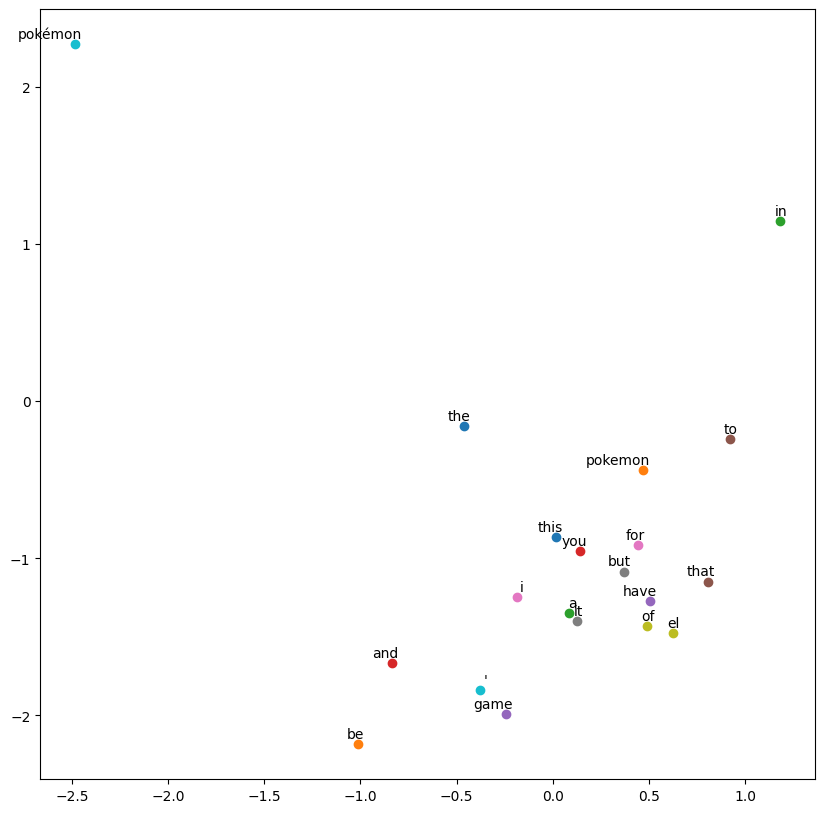

In [58]:
plt.figure(figsize=(10, 10))
for i, word in enumerate(list(tokenizer.word_index.keys())[:20]):
  x, y = reduced_embeddings[i]
  plt.scatter(x, y)
  plt.annotate(word, xy=(x, y), xytext=(5, 2),
                textcoords='offset points',
                ha='right', va='bottom')
plt.show()

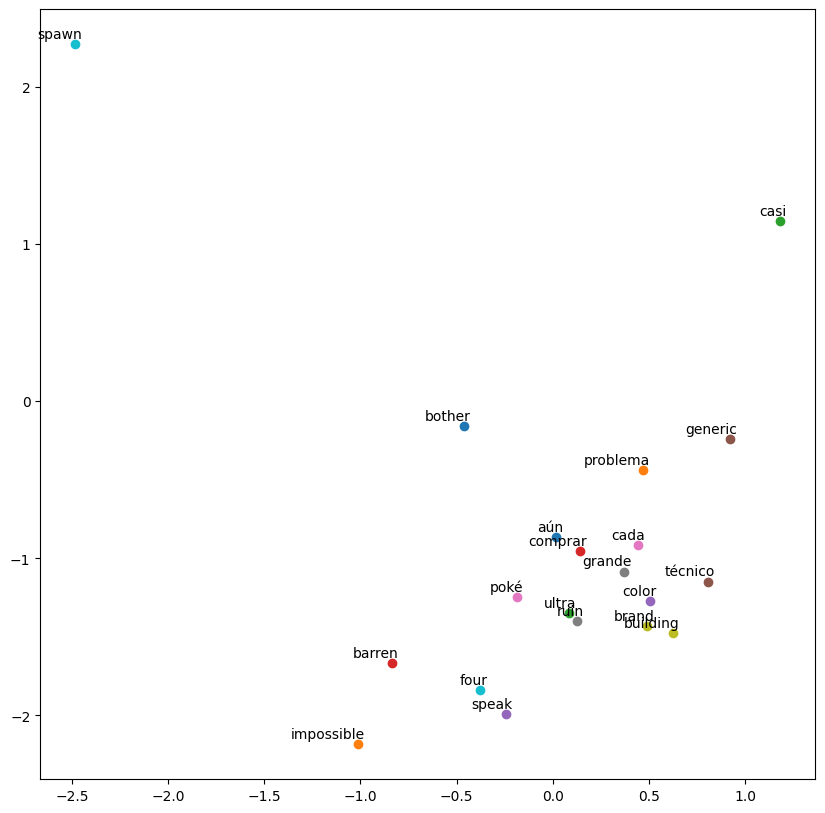

In [59]:
plt.figure(figsize=(10, 10))
for i, word in enumerate(list(tokenizer.word_index.keys())[1000:1020]):
  x, y = reduced_embeddings[i]
  plt.scatter(x, y)
  plt.annotate(word, xy=(x, y), xytext=(5, 2),
                textcoords='offset points',
                ha='right', va='bottom')
plt.show()

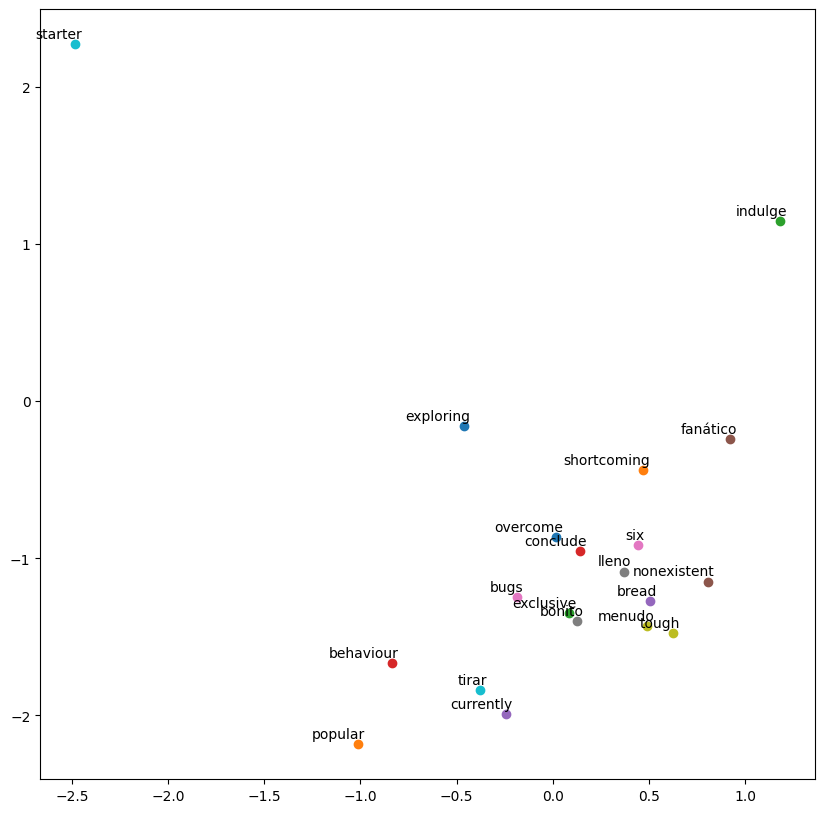

In [60]:
plt.figure(figsize=(10, 10))
for i, word in enumerate(list(tokenizer.word_index.keys())[2000:2020]):
  x, y = reduced_embeddings[i]
  plt.scatter(x, y)
  plt.annotate(word, xy=(x, y), xytext=(5, 2),
                textcoords='offset points',
                ha='right', va='bottom')
plt.show()

Como podemos ver en las gráficas anteriores, el modelo creo algunas agrupaciones de acuerdo a los datos otorgados, interpretando el contexto en el cual se encontraban estas.

Podemos algunas palabras similares entre ellas o que tiene una relación real, como:
- bonito - exclusivo -> características / adjetivos.
- this - you -> sustantivos
- grande - ultra -> adjetivos

Es interesante ver como es que el modelo interpreta su similarida o relación a apartir de los datos otorgados.

## Conclusiones

Durante esta práctica se pudo entender un poco más el concepto de redes recurrentes y LSTM's, además de poder conocer un poco sobre el aprendizaje no-supervisado y este como funciona.

El problema para poder enteder estos temas fue la creación de un modelo CBOW mediante un conjunto de datos.

A lo largo de la creación de este modelo se pudo entender más su funcionamiento y sus bases, además de los objetivos y cómo estos se adaptan a los objetivos de la práctica. Principalmente, como es que el modelo crea agrupaciones con base a los datos de entrenamiento y ninguna otra información.

Con lo mencionado anteriormente, se adquiere un nuevo conocimiento sobre redes neuronales y se refuerzan las bases sobre el aprendizaje no-supervisado.

